# To run this successfully, run every cell from top to bottom

### Note: Every cell has already been run by me, and results are shown, so there is no need to actually run everything.

In [115]:
# For the purpose of this project, I used a dataset I found in Kaggle, called "Fashion-MNIST" which is a slight
# variation to the commonly known MNIST dataset. I decided to use the "Fashion-MNIST" dataset just to differ from 
# the others hehe.

# Link: https://www.kaggle.com/zalando-research/fashionmnist

In [2]:
# Here we import all the need libraries

import pandas as pd
import numpy as np
import heapq
import timeit

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import classification_report

In [3]:
# Load the datasets from the FashionMNIST folder.

data_train = pd.read_csv("./FashionMNIST/fashion-mnist_train.csv")
data_test = pd.read_csv("./FashionMNIST/fashion-mnist_test.csv")

In [4]:
# Dictionary to indicate which class number corresponds to which type of clothing

fashionmnist = {
    "0": "T-shirt/top",
    "1": "Trouser",
    "2": "Pullover",
    "3": "Dress",
    "4": "Coat",
    "5": "Sandal",
    "6": "Shirt",
    "7": "Sneaker",
    "8": "Bag",
    "9": "Ankle boot",
}

In [5]:
# Representation of how the dataset looks like.

data_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Split the train and test dataframes into features(X) and labels(Y)

X_train = data_train.drop(["label"],axis=1)
Y_train = data_train[["label"]].values.ravel()
X_test = data_test.drop(["label"],axis=1)
Y_test = data_test[["label"]].values.ravel()

# I used .ravel() due to some inconsistences with the dataset (..Thanks StackOverflow :D)

# Also, since all features range from 0 to 255, we don't need to normalize them.

In [7]:
# We can look at how many rows and columns each dataset has

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [8]:
# Function to create different kind of sizes for training datasets (For testing purposes)

def create_dataset(size):
    """makes a dataset of size "size", and returns that datasets images and targets
    This is used to make the dataset that will be stored by a model and used in 
    experimenting with different stored dataset sizes
    """
    small_x_train = X_train[:size]
    small_y_train = Y_train[:size]
    
    return small_x_train, small_y_train


In [9]:
# Function to create different kind of sizes for testing datasets (For testing purposes)

def create_test_dataset(size):
    """makes a dataset of size "size", and returns that datasets images and targets
    This is used to make the dataset that will be tested by a model and used in 
    experimenting with different test dataset sizes
    """
    small_x_test = X_test[:size]
    small_y_test = Y_test[:size]
    
    return small_x_test, small_y_test

In [244]:
# Smaller train set of 1000 rows (I put it 60000 for the final project)

small_x_train, small_y_train = create_dataset(60000)

small_x_train.shape, small_y_train.shape

((60000, 784), (60000,))

In [245]:
# Smaller test set of 1000 rows (I put it 10000 for the final project)

small_x_test, small_y_test = create_test_dataset(10000)

small_x_test.shape, small_y_test.shape

((10000, 784), (10000,))

In [222]:
# Import some important libraries and features


import matplotlib.pyplot as plt

In [229]:
import numpy as np


# function to get the euclidean distance between 2 points

def get_distance(x1, x2):
    sum = 0
    for i in range(len(x1)):
        sum += (x1[i] - x2[i]) ** 2
    return np.sqrt(sum)


# function for choosing random centroids

def random_centroids(X, k):
  
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]

    return np.array(centroids)

In [129]:
# Code snippet by https://gist.github.com/tarlanahad/

In [152]:
from sklearn.cluster import KMeans

# class for radial basis function

class RBF:

    def __init__(self, X, y, tX, ty, centroids_method, num_of_classes,
                 k):
        self.X = X
        self.y = y

        self.tX = tX
        self.ty = ty
        
        self.centroids_method = centroids_method

        self.number_of_classes = num_of_classes
        self.k = k

        
    # one-hot-encoding of labels
    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    # calculate an exponential function with a negative power of the euclidean distance 
    # between a point and its cluster's centroid 
    def rbf(self, x, c, s):
        distance = get_distance(x, c)
        return 1 / np.exp(-distance / s ** 2)

    # calculate the data matrix with activation functions
    def rbf_list(self, X, centroids, beta):
        RBF_list = []
        for x in X:
            RBF_list.append([self.rbf(x, c, s) for (c, s) in zip(centroids, beta)])

        return np.array(RBF_list)
    
    # run rbfnn
    def fit(self):

        start = timeit.default_timer()
        
        # choose how centers will be selected
        if self.centroids_method == "kmeans":
            kmeans = KMeans(n_clusters=self.k, random_state=0).fit(self.X)
            self.centroids = kmeans.cluster_centers_
        elif self.centroids_method == "random":
            self.centroids = random_centroids(self.X,self.k)
        
        stop = timeit.default_timer()
        time1 = stop - start
        print('Time1: ', time1)


        
        # calculate the maximum distance between two centroids
        dMax = np.max([get_distance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
        # use dMax to calculate the beta(β) coefficient, representing the gaussian processes' range
        self.beta = np.repeat(dMax / np.sqrt(2 * self.k), self.k)


        start = timeit.default_timer()
        
        # calculate data matrix A of activation functions, after hidden centroid layer 
        A = self.rbf_list(self.X, self.centroids, self.beta)
        
        stop = timeit.default_timer()
        time3 = stop - start
        print('Time3: ', time3)

        
        # Find the absolute minimum of error using linear algebra, and calculate the w
        self.w = np.linalg.pinv(A.T @ A) @ A.T @ self.convert_to_one_hot(self.y, self.number_of_classes)
        
        

        start = timeit.default_timer()
        
        # Calculate data matrix B of the test set
        B = self.rbf_list(self.tX, self.centroids, self.beta)
        
        stop = timeit.default_timer()
        time5 = stop - start
        print('Time5: ', time5)

        
        # Use the calculated weights
        self.pred_ty = B @ self.w
        
        # Find predictions based on the highest value (probability)
        self.pred_ty = np.array([np.argmax(x) for x in self.pred_ty])
        
        # Caclulate accuracy
        diff = self.pred_ty - self.ty
        

        print('Accuracy: ', len(np.where(diff == 0)[0]) / len(diff))
        
        print('Total time: ', time1+time3+time5)
        
        return (self.pred_ty)

### BEWARE: The functions below run for hours

In [114]:
k_values = [200,500]
for k in k_values:
    print("K = ",k)
    RBF_CLASSIFIER = RBF(small_x_train.values, small_y_train, small_x_test.values, small_y_test, "random", 10, k)

    RBF_CLASSIFIER.fit()

K =  200
Time1:  1.797020000012708
Time3:  8632.910195599994
Time5:  1501.066347999993
Accuracy:  0.8312
Total time:  10135.7735636
K =  500
Time1:  1.515424700002768
Time3:  20489.260198200005
Time5:  3409.522173999998
Accuracy:  0.8575
Total time:  23900.297796900006


In [ ]:
k_values = [20,50]
for k in k_values:
    print("K = ",k)
    RBF_CLASSIFIER = RBF(small_x_train.values, small_y_train, small_x_test.values, small_y_test, "kmeans", 10, k)

    RBF_CLASSIFIER.fit()

### Confusion Matrix on test set prediction

In [224]:
print(confusion_matrix(small_y_test, pred))

[[775   6  25  98   9  13  34   1  39   0]
 [  3 918  15  47  10   3   4   0   0   0]
 [ 33   2 578  17 217  18 113   1  21   0]
 [ 37  15   6 880  23   8  22   0   9   0]
 [  0   7 105  74 698   5 103   0   8   0]
 [  3   0   0   0   0 746   0 167  13  71]
 [227   1 121  81 151  13 370   0  35   1]
 [  0   0   0   0   0  88   0 794   2 116]
 [  2   0  23  13   6  20   8  19 906   3]
 [  0   0   0   0   0  25   0  48   0 927]]


## Παράδειγμα εσφαλμένης κατηγοριοποίησης

Example of wrong classification:
Predicted: = Shirt
True value: = Pullover


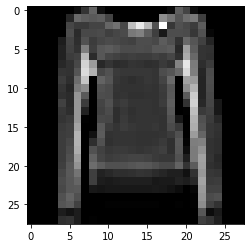

In [247]:
# Example of wrong classification

for i in range(len(pred)):
    if(pred[i]!=small_y_test[i]):
        c=i
        break


print("Example of wrong classification:")
print("Predicted: = " + fashionmnist[str(pred[c])])
print("True value: = " + fashionmnist[str(small_y_test[c])])
image = small_x_test.iloc[c]
temp = np.array(image)
temp = np.reshape(temp, (28,28))
# plot the sample
fig = plt.figure
plt.imshow(temp, cmap='gray')
plt.show()

## Παράδειγμα σωστής κατηγοριοποίησης

Example of correct classification:
Predicted: = T-shirt/top
True value: = T-shirt/top


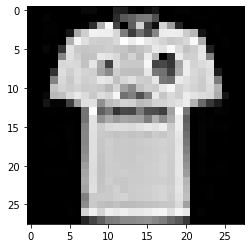

In [226]:
# Example of correct classification

for i in range(len(pred)):
    if(pred[i]==small_y_test[i]):
        c=i
        break

print("Example of correct classification:")
print("Predicted: = " + fashionmnist[str(pred[c])])
print("True value: = " + fashionmnist[str(small_y_test[c])])
image = small_x_test.iloc[c]
temp = np.array(image)
temp = np.reshape(temp, (28,28))
# plot the sample
fig = plt.figure
plt.imshow(temp, cmap='gray')
plt.show()

# ΠΕΙΡΑΜΑΤΙΣΜΟΙ ΚΑΙ ΣΥΓΚΡΙΣΕΙΣ ΠΑΡΑΜΕΤΡΩΝ

## Πειραματισμός σε test set και training set ( συγκρίσεις ακρίβειας ως προς το πλήθος κρυφών νευρώνων k, 1000 samples )

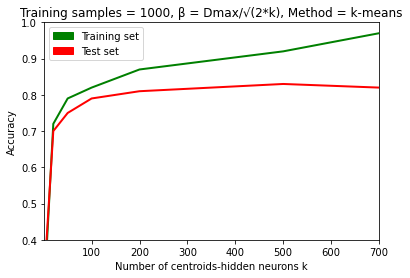

In [218]:
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
  
# x axis values 
x = [5,20,50,100,200,500,700] 

# corresponding y axis values 
no1 = [0.35,0.72,0.79,0.82,0.87,0.92,0.97] 
no2 = [0.38,0.70,0.75,0.79,0.81,0.83,0.82] 

  
# plotting the points  
plt.plot(x, no1, color='green', linewidth = 2) 
plt.plot(x, no2, color='red', linewidth = 2) 


green = mpatches.Patch(color='green', label='Training set')
red = mpatches.Patch(color='red', label='Test set')

plt.legend(handles=[green,red])
  
# setting x and y axis range 
plt.ylim(0.4,1) 
plt.xlim(1,700) 
  
# naming the x axis 
plt.xlabel('Number of centroids-hidden neurons k') 
# naming the y axis 
plt.ylabel('Accuracy') 
  
# giving a title to my graph 
plt.title('Training samples = 1000, β = Dmax/√(2*k), Method = k-means') 
  
# function to show the plot 
plt.show() 

## Πειραματισμός σε test set ( συγκρίσεις ακρίβειας ως προς το πλήθος κρυφών νευρώνων k, 60.000 samples )

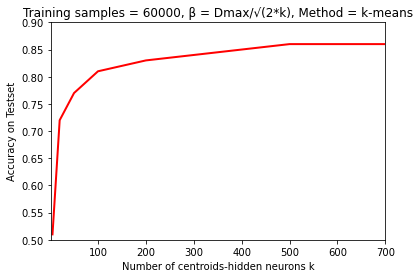

In [217]:
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
  
# x axis values 
x = [5,20,50,100,200,500,700] 

# corresponding y axis values 
no1 = [0.51,0.72,0.77,0.81,0.83,0.86,0.86] 


  
# plotting the points  
plt.plot(x, no1, color='red', linewidth = 2) 

  
# setting x and y axis range 
plt.ylim(0.5,0.9) 
plt.xlim(1,700) 
  
# naming the x axis 
plt.xlabel('Number of centroids-hidden neurons k') 
# naming the y axis 
plt.ylabel('Accuracy on Testset') 
  
# giving a title to my graph 
plt.title('Training samples = 60000, β = Dmax/√(2*k), Method = k-means') 
  
# function to show the plot 
plt.show() 

## Πειραματισμός σε test set ( συγκρίσεις ακρίβειας ως προς το πλήθος training δεδομένων )

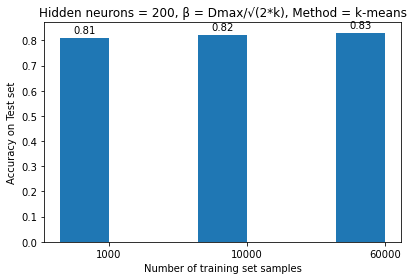

In [216]:

labels = ['1000', '10000', '60000']
shuffled = [0.81, 0.82, 0.83]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, shuffled, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy on Test set')
ax.set_xlabel('Number of training set samples')
ax.set_title('Hidden neurons = 200, β = Dmax/√(2*k), Method = k-means')
ax.set_xticks(x)
ax.set_xticklabels(labels)




def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

fig.tight_layout()

plt.show()



## Πειραματισμός σε test set ( συγκρίσεις ακρίβειας ως προς μέθοδο επιλογής κέντρων (k-means/random) )

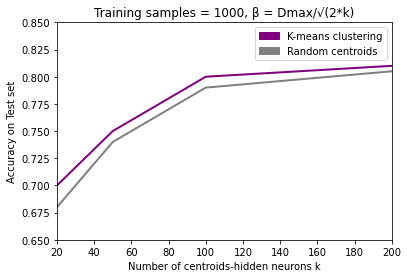

In [215]:
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
  
# x axis values 
x = [20,50,100,200] 

# corresponding y axis values 
no1 = [0.70,0.75,0.80,0.81] 
no2 = [0.68,0.74,0.79,0.805] 

  
# plotting the points  
plt.plot(x, no1, color='purple', linewidth = 2) 
plt.plot(x, no2, color='grey', linewidth = 2) 


purple = mpatches.Patch(color='purple', label='K-means clustering')
grey = mpatches.Patch(color='grey', label='Random centroids')

plt.legend(handles=[purple,grey])
  
# setting x and y axis range 
plt.ylim(0.65,0.85) 
plt.xlim(20,200) 
  
# naming the x axis 
plt.xlabel('Number of centroids-hidden neurons k') 
# naming the y axis 
plt.ylabel('Accuracy on Test set') 
  
# giving a title to my graph 
plt.title('Training samples = 1000, β = Dmax/√(2*k)') 
  
# function to show the plot 
plt.show() 

## Πειραματισμός σε test set ( συγκρίσεις ακρίβειας ως προς μέθοδο επιλογής β )

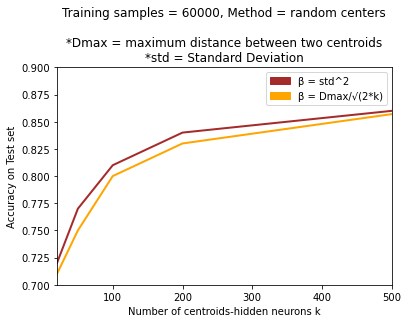

In [230]:
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
  
# x axis values 
x = [20,50,100,200,500] 

# corresponding y axis values 
no1 = [0.71,0.75,0.80,0.83,0.857] 
no2 = [0.72,0.77,0.81,0.84,0.86] 

  
# plotting the points  
plt.plot(x, no1, color='orange', linewidth = 2) 
plt.plot(x, no2, color='brown', linewidth = 2) 


orange = mpatches.Patch(color='orange', label='β = Dmax/√(2*k)')
brown = mpatches.Patch(color='brown', label='β = std^2')

plt.legend(handles=[brown,orange])
  
# setting x and y axis range 
plt.ylim(0.7,0.9) 
plt.xlim(20,500) 
  
# naming the x axis 
plt.xlabel('Number of centroids-hidden neurons k') 
# naming the y axis 
plt.ylabel('Accuracy on Test set') 
  
# giving a title to my graph 
plt.title('Training samples = 60000, Method = random centers\n\n*Dmax = maximum distance between two centroids\n*std = Standard Deviation') 
  
# function to show the plot 
plt.show() 